In [1]:
!pwd

/home/szabopal/PycharmProjects/veszprem/veszprembe_vitt_geprol_fajlok/veszpremOC


In [2]:
import pandas as pd
import glob

In [3]:
#TESS_RRL_list=set(glob.glob('TESS_RRLs/*txt'))-set(glob.glob('TESS_RRLs/*extended_details.txt'))

In [4]:
#for each in TESS_RRL_list:
#    print(each)
#    df=pd.read_csv(each,sep=r"\s*",engine='python')
#    BJD=df.iloc[:,1]
#    flux=df.iloc[:,6]
#    fluxerror=df.iloc[:,7]

In [5]:
#df=pd.read_csv(each,sep=r"\s*")
#BJD=df.iloc[:,1]
#flux=df.iloc[:,6]
#fluxerror=df.iloc[:,7]

In [6]:
import sys
terminalpythonpath=['', '/home/szabopal/PycharmProjects/venv36/lib/python36.zip', '/home/szabopal/PycharmProjects/venv36/lib/python3.6', '/home/szabopal/PycharmProjects/venv36/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/szabopal/PycharmProjects/venv36/lib/python3.6/site-packages']
[sys.path.append(each) for each in terminalpythonpath]
import matplotlib.pyplot as plt

In [7]:
#!pip3 install scipy
#!pip3 install uncertainties
#!pip3 install gatspy

In [8]:

#import zastro as z
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import glob
import pandas as pd
from uncertainties import ufloat
import numpy as np
import pandas as pd
import os
import warnings
from scipy.optimize import OptimizeWarning
import matplotlib.gridspec as gridspec
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast


In [9]:
def whitening(time, signaltowhiten, best_freq = False):
    dowewantplots=False
    
    #write out every 32th roughly:
  #  if (np.random.rand() > 0.5 and 
  #      np.random.rand() > 0.5 and
  #      np.random.rand() > 0.5 and
  #      np.random.rand() > 0.5 and 
  #      np.random.rand() > 0.5):
  #      
  #      dowewantplots = True
    
    #print(time)
    #print(signaltowhiten)
    

    if not best_freq:
        ls = LombScargle(time, signaltowhiten, nterms=1)
        #nyquist = len(time)/(2*(max(time)-min(time)))
        freq, power = ls.autopower(normalization='psd',nyquist_factor=1, samples_per_peak=10)

        if dowewantplots:
            plt.plot(freq, power);
            plt.show()

        best_freq = freq[power.argmax()]
        best_power = power[power.argmax()]
        signalfit = ls.model(time, best_freq)


        pfit, pcov = optimize.curve_fit(lambda time, amp, phase: sine(time, amp, best_freq, phase),
                                                     time, signalfit-np.mean(signalfit))
    else:
        pfit, pcov = optimize.curve_fit(lambda time, amp, phase: sine(time, amp, best_freq, phase),
                                                     time, signaltowhiten-np.mean(signaltowhiten))
    
    
    if dowewantplots: 
        
        plt.figure(figsize=(15,5))
        if not best_freq: 
            plt.plot(time, signalfit, alpha=0.5, c='b')

            plt.plot(np.linspace(min(time),max(time),10000),
                                                  np.mean(signalfit)+sine(np.linspace(min(time),max(time),10000),
                                                  pfit[0], # ez a fittelt ampli az LS fitre 
                                                  best_freq, 
                                                  pfit[1]),
                                                  c='r')

        else:
            plt.plot(np.linspace(min(time),max(time),10000),
                                                  np.mean(signaltowhiten)+sine(np.linspace(min(time),max(time),
                                                  10000),
                                                  pfit[0], # ez a fittelt ampli az LS fitre 
                                                  best_freq, 
                                                  pfit[1]),
                                                  c='r')

            
            
        plt.plot(time, signaltowhiten,alpha=0.5)
        #plt.plot(time, signaltowhiten-signalfit)
        plt.xlim(min(time),min(time)+1)
        #plt.xlim([2440,2450])
        plt.show()
    
    #powerstd = np.std(power)
    
    #return freq, power, signalfit, best_freq, best_power, powerstd
    
    if not best_freq:
        return (pfit[0], #amp
               pfit[1], # phase 
               best_freq, signalfit)
    else:
        return (pfit[0], pfit[1], best_freq, np.mean(signaltowhiten)+sine(BJD,
                                                  pfit[0], # ez a fittelt ampli az LS fitre 
                                                  best_freq, 
                                                  pfit[1]))
    
def sine(x,amp,freq,phase):
    return amp*np.sin(x*2*np.pi*freq + phase)

In [7]:
def fitter(filename):
    def F(x, A_0,
          A_1, phi_1,A_2, phi_2,A_3, phi_3,A_4, phi_4,A_5, phi_5,A_6, phi_6,freq):
        return (A_0+A_1*np.sin(2*np.pi*1*freq*x+phi_1)+
                    A_2*np.sin(2*np.pi*2*freq*x+phi_2)+
                    A_3*np.sin(2*np.pi*3*freq*x+phi_3)+
                    A_4*np.sin(2*np.pi*4*freq*x+phi_4)+
                    A_5*np.sin(2*np.pi*5*freq*x+phi_5)+
                    A_6*np.sin(2*np.pi*6*freq*x+phi_6))
    
    df=pd.read_csv(filename,sep=r"\s*")
    BJD=df.iloc[:,1]
    flux=df.iloc[:,6]
    fluxerror=df.iloc[:,7]
        
    model = LombScargleFast().fit(BJD, flux)
    
    NYQ=len(BJD)/(2*(max(BJD)-min(BJD)))
    periods, power = model.periodogram_auto(NYQ)
    model.optimizer.period_range=(0.1, 1.4)
    period = model.best_period
    print('##########')
    print(str(period))
    print('##########')
    
    
    LSPfreq=1/period

    pfit, pcov=optimize.curve_fit(lambda x, _A_0, 
                                      _A_1, _phi_1,
                                      _A_2, _phi_2,
                                      _A_3, _phi_3,
                                      _A_4, _phi_4,
                                      _A_5, _phi_5,
                                      _A_6, _phi_6,_freqfit:

                                      F(x, _A_0,_A_1, _phi_1,
                                                _A_2, _phi_2,
                                                _A_3, _phi_3,
                                                _A_4, _phi_4,
                                                _A_5, _phi_5,
                                                _A_6, _phi_6,_freqfit),

                                      BJD, flux, 
                                                 p0=[100, 100, 0,
                                                          100, 0,
                                                          100, 0,
                                                          100, 0,
                                                          100, 0,
                                                          100, 0,
                                                          LSPfreq],

                                                     sigma=fluxerror, absolute_sigma=True)

    error = [] # DEFINE LIST TO CALC ERROR
    for i in range(len(pfit)): 
        try:error.append(np.absolute(pcov[i][i])**0.5) # CALCULATE SQUARE ROOT OF TRACE OF COVARIANCE MATRIX
        except:error.append( 0.00 )     
    perr_curvefit = np.array(error)
    
    plt.figure(figsize=(20,8))
    plt.plot(BJD, flux)
    plt.plot(BJD, F(BJD, *pfit))
    plt.xlim(min(BJD),min(BJD)+5)
    plt.show()
    
    
    return BJD, flux, fluxerror, pfit, perr_curvefit, LSPfreq

In [8]:
def splitthem(inputBJD,inputflux,fluxerror,bar,n):
    df = pd.DataFrame({'BJD':inputBJD,'flux':inputflux,'fluxerror':fluxerror})
    dfbit=df[(df['BJD']<df['BJD'].iloc[0]+bar*(n+1)) & (df['BJD']>=df['BJD'].iloc[0]+bar*n)]
    dfbitlistBJD=dfbit['BJD'].tolist()
    dfbitlistflux=dfbit['flux'].tolist()
    dfbitlistfluxerror=dfbit['fluxerror'].tolist()
    if not dfbitlistBJD: raise ValueError("there arent that manyth period as you requested")
    return dfbitlistBJD, dfbitlistflux, dfbitlistfluxerror

In [10]:
def splitthem2(inputBJD, inputflux,fluxerror,span,step,n):
    df = pd.DataFrame({'BJD':inputBJD,'flux':inputflux,'fluxerror':fluxerror})
    dfbit=df[(df['BJD']<df['BJD'].iloc[0]+step*n+span) & (df['BJD']>=df['BJD'].iloc[0]+step*n)]
    dfbitlistBJD=dfbit['BJD'].tolist()
    dfbitlistflux=dfbit['flux'].tolist()
    dfbitlistfluxerror=dfbit['fluxerror'].tolist()
    if not dfbitlistBJD: raise ValueError("there arent that manyth period as you requested")
    return dfbitlistBJD, dfbitlistflux, dfbitlistfluxerror

In [11]:
def FFF(x, a0, a, psi, resdict):
        return (a0*resdict['A_0']+
                a*resdict['A_1']*np.sin(2*np.pi*1*resdict['freqfit']*x+resdict['phi_1']+1*psi)+
                a*resdict['A_2']*np.sin(2*np.pi*2*resdict['freqfit']*x+resdict['phi_2']+2*psi)+
                a*resdict['A_3']*np.sin(2*np.pi*3*resdict['freqfit']*x+resdict['phi_3']+3*psi)+
                a*resdict['A_4']*np.sin(2*np.pi*4*resdict['freqfit']*x+resdict['phi_4']+4*psi)+
                a*resdict['A_5']*np.sin(2*np.pi*5*resdict['freqfit']*x+resdict['phi_5']+5*psi))
               # a*resdict['A_6']*np.sin(2*np.pi*6*resdict['freqfit']*x+resdict['phi_6']+6*psi))

In [12]:
import json
import os.path
import re
import ipykernel
import requests

#try:  # Python 3
#    from urllib.parse import urljoin
#except ImportError:  # Python 2
#    from urlparse import urljoin

# Alternative that works for both Python 2 and 3:
from requests.compat import urljoin

try:  # Python 3 (see Edit2 below for why this may not work in Python 2)
    from notebook.notebookapp import list_running_servers
except ImportError:  # Python 2
    import warnings
    from IPython.utils.shimmodule import ShimWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ShimWarning)
        from IPython.html.notebookapp import list_running_servers


def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return os.path.join(ss['notebook_dir'], relative_path)
            
import datetime

In [13]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [33]:
for eachperiodguess in np.arange(-0.4, 0.5, 0.1):
    print(eachperiodguess)

-0.4
-0.30000000000000004
-0.20000000000000007
-0.10000000000000009
-1.1102230246251565e-16
0.09999999999999987
0.19999999999999984
0.2999999999999998
0.3999999999999998


In [32]:
np.linspace(-0.4, 0.5, 0.1)

array([], dtype=float64)

TESS_RRLs/ao-ind-s1-rp.txt


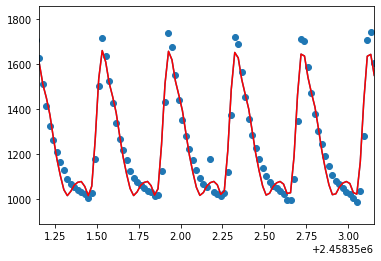

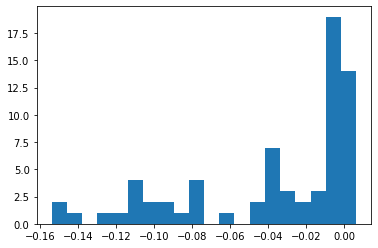

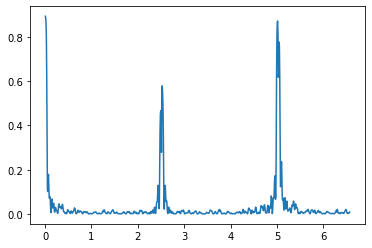

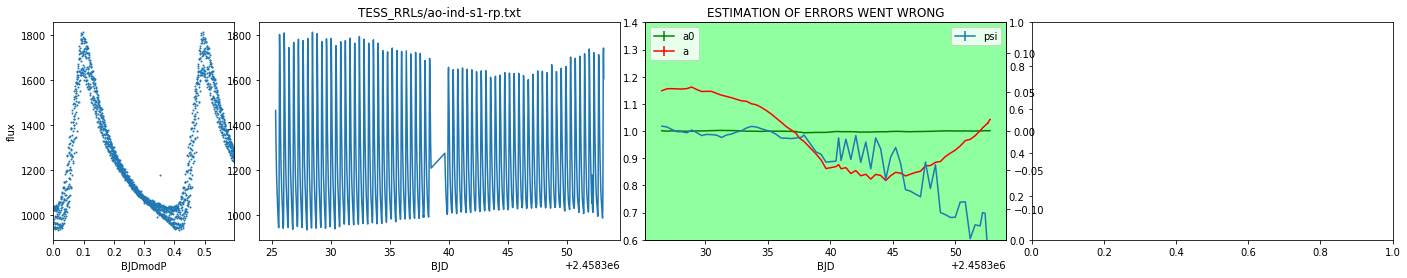

TESS_RRLs/ao-ind-s1-rp.txt


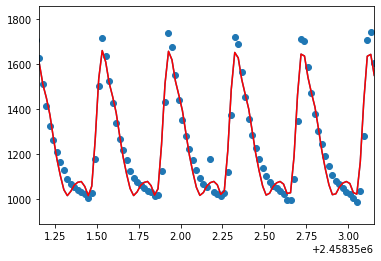

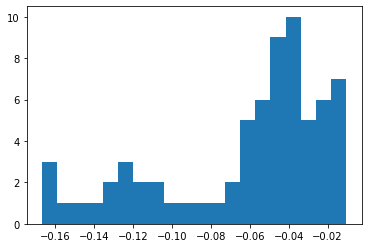

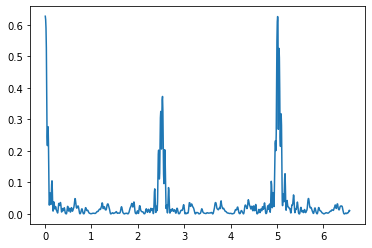

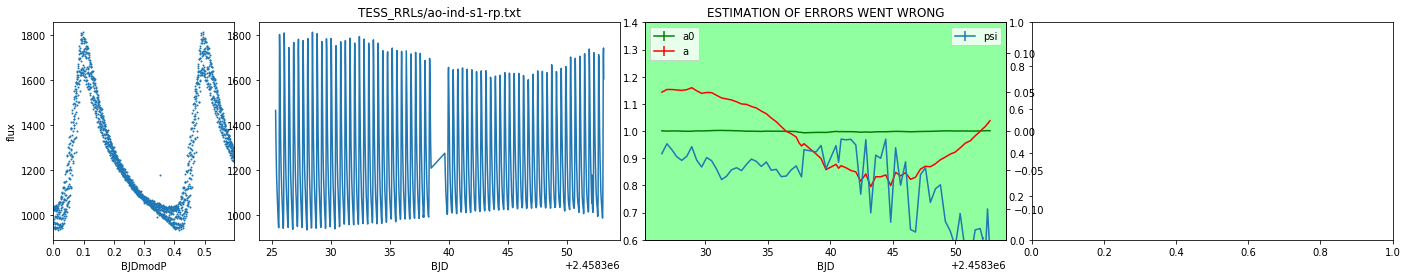

TESS_RRLs/ao-ind-s1-rp.txt


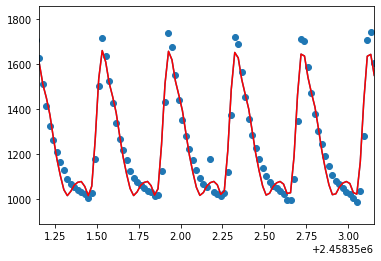

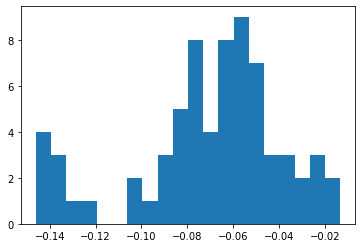

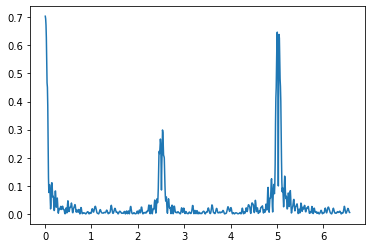

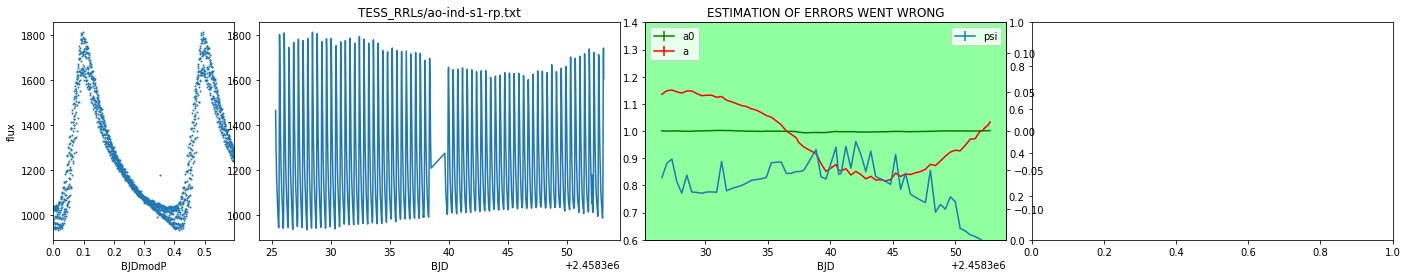

TESS_RRLs/ao-ind-s1-rp.txt


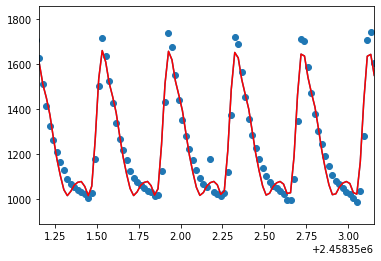

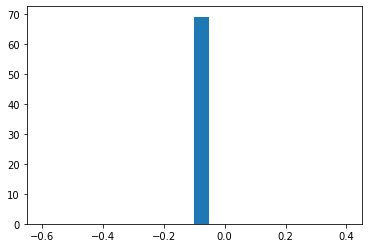

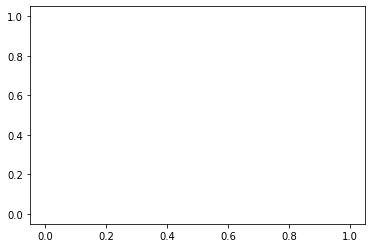

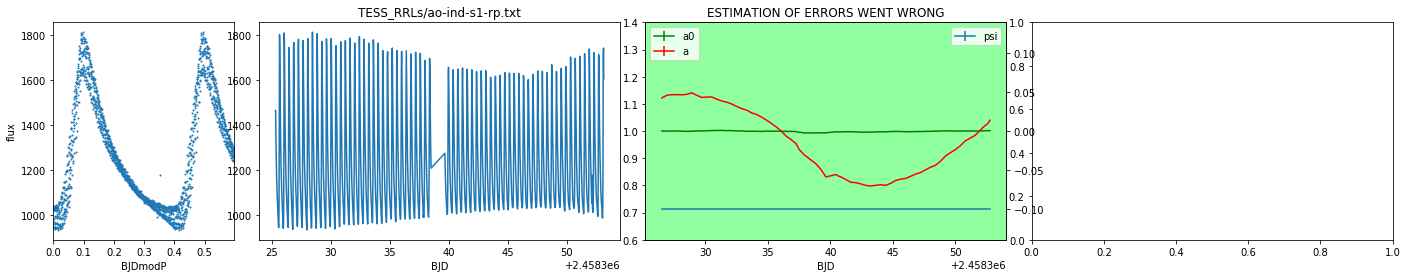

TESS_RRLs/ao-ind-s1-rp.txt


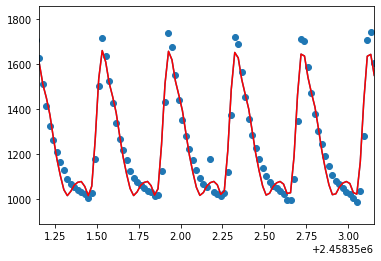

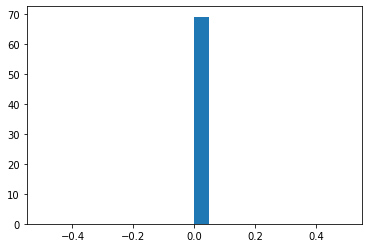

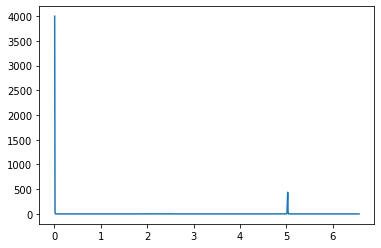

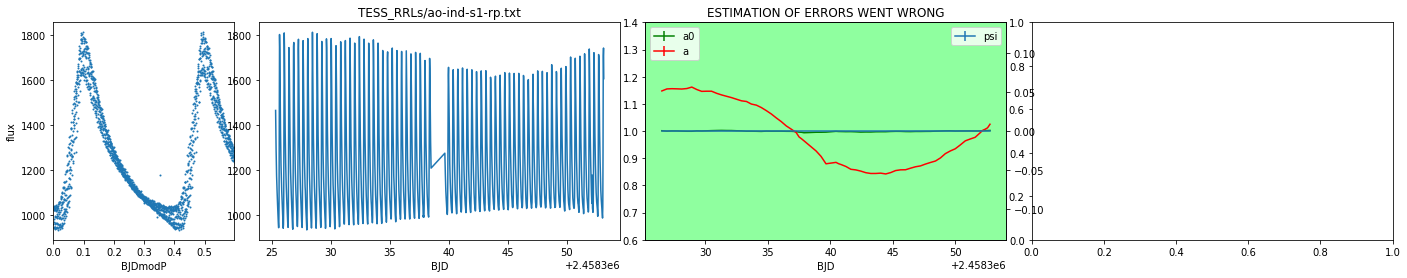

TESS_RRLs/ao-ind-s1-rp.txt


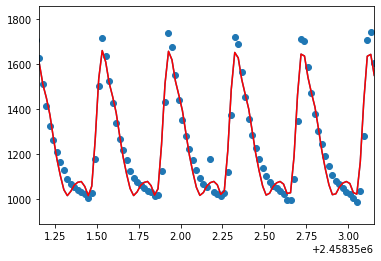

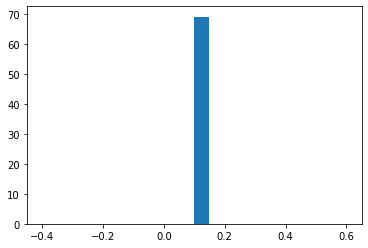

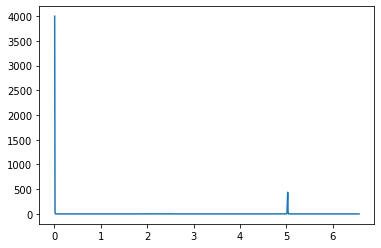

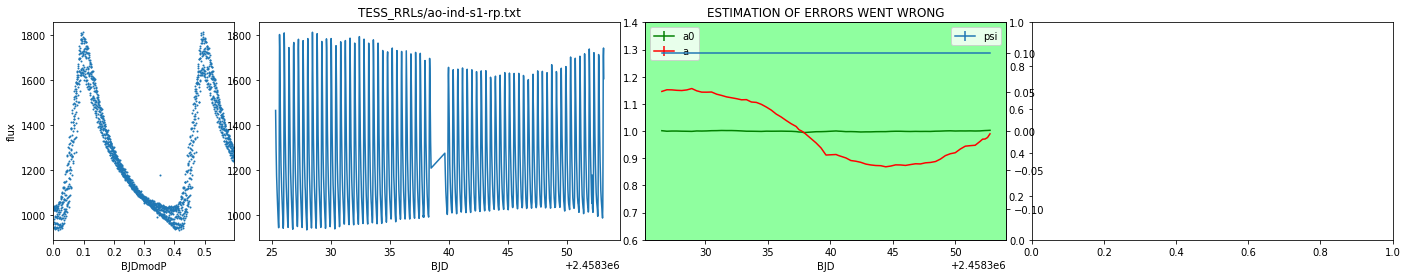

TESS_RRLs/ao-ind-s1-rp.txt


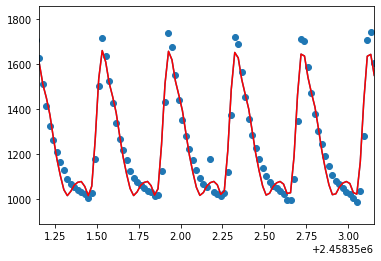

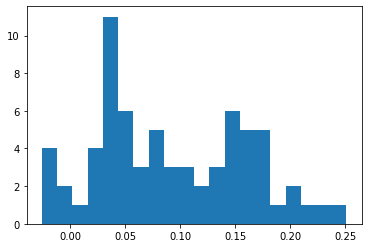

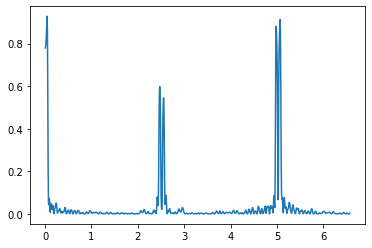

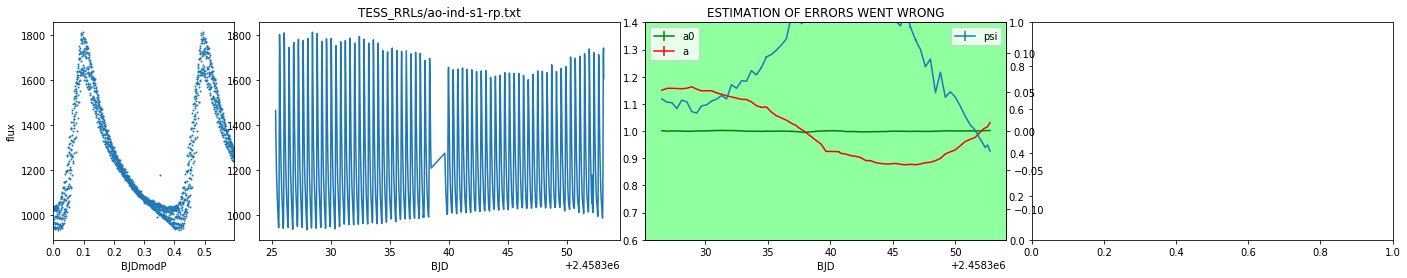

TESS_RRLs/ao-ind-s1-rp.txt


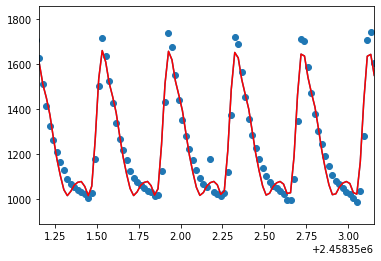

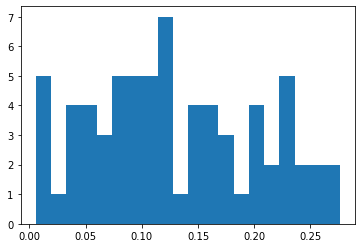

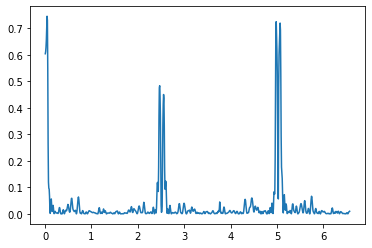

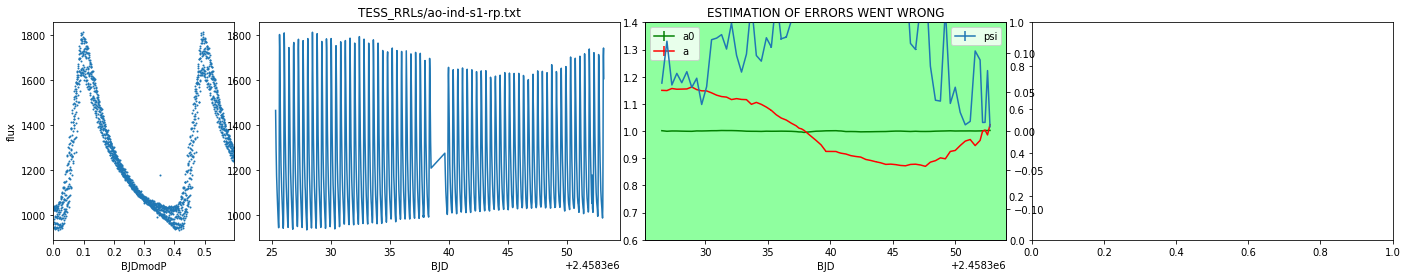

TESS_RRLs/ao-ind-s1-rp.txt


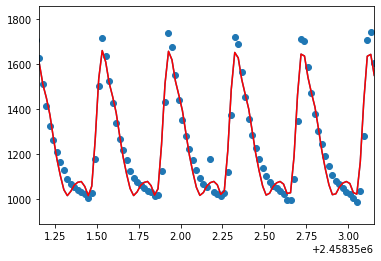

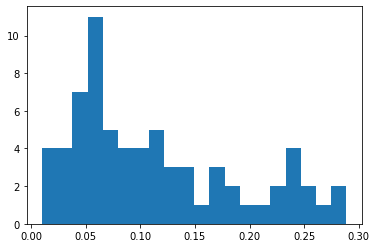

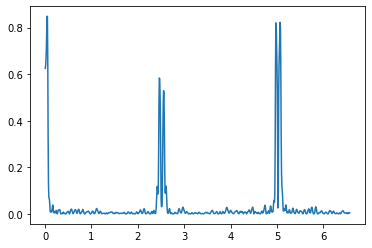

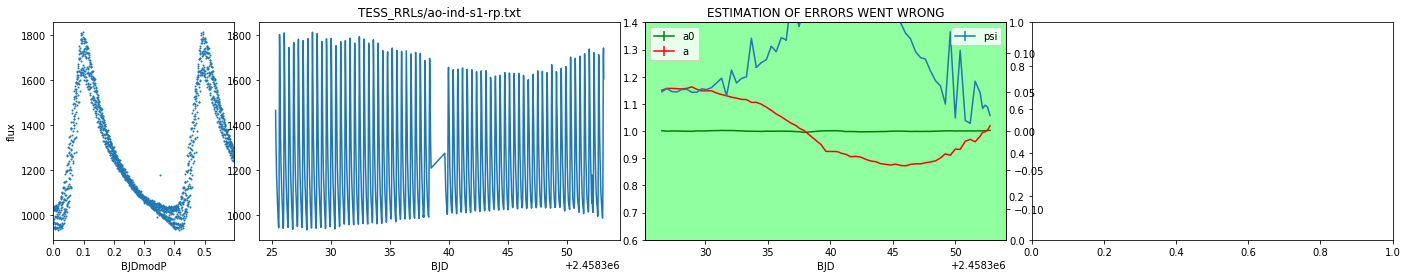

In [36]:
for eachperiodguess in np.arange(-0.4, 0.5, 0.1):

    #%%capture
    import warnings
    warnings.filterwarnings("ignore")

    #objlist=glob.glob("/home/szabopal/PycharmProjects/veszprem/veszprembe_vitt_geprol_fajlok/veszpremOC/TESS_RRLs/*txt")
    objlist=set(glob.glob('TESS_RRLs/ao-ind*txt'))-set(glob.glob('TESS_RRLs/*extended_details.txt'))
    #objlist=set(glob.glob('TESS_RRLs/*txt'))-set(glob.glob('TESS_RRLs/*extended_details.txt'))

    mmampl=[];mmphase=[];medflux=[];deltaaerrors=[];deltapsierrors=[]


    for index, line in enumerate(objlist):

        #if index<5:
        #if True: # for debug
        #if index>300: # for debug

        #if index>0:
        if True:
            print(line)

            if file_len(line)<2000: # short cadencekre nem fut


                df=pd.read_csv(line,sep=r"\s*")
                BJD=df.iloc[:,1]
                flux=df.iloc[:,6]
                fluxerror=df.iloc[:,7]


          #      BJD, flux, fluxerror, pfit, perr_curvefit, LSPfreq =fitter(line)

          #      (A_0,
          #       A_1, phi_1,
          #       A_2, phi_2,
          #       A_3, phi_3,
          #       A_4, phi_4,
          #       A_5, phi_5,
          #       A_6, phi_6,
          #       freqfit) = pfit


          #      (err_A_0,
          #       err_A_1,  err_phi_1,
          #       err_A_2,  err_phi_2,
          #       err_A_3,  err_phi_3,
          #       err_A_4,  err_phi_4,
          #       err_A_5,  err_phi_5,
          #       err_A_6,  err_phi_6,
          #       err_freqfit) = perr_curvefit

                resdict={}
             #   resdict['A_0']     =  pfit[0]
             #   resdict['A_1']     =  pfit[1]
             #   resdict['phi_1']   =  pfit[2]
             #   resdict['A_2']     =  pfit[3]
             #   resdict['phi_2']   =  pfit[4]
             #   resdict['A_3']     =  pfit[5]
             #   resdict['phi_3']   =  pfit[6]
             #   resdict['A_4']     =  pfit[7]
             #   resdict['phi_4']   =  pfit[8]
             #   resdict['A_5']     =  pfit[9]
             #   resdict['phi_5']   =  pfit[10]
             #   resdict['A_6']     =  pfit[11]
             #   resdict['phi_6']   =  pfit[12]
             #   resdict['freqfit'] =  pfit[13]

                amplist=[]
                freqlist=[]
                phaselist=[]

                residual = flux
                for x in range(5):
                    if x==0:
                        amp, phase, freq, signalfit = whitening(BJD,residual)
                        LSPfreq = freq
                    else:
                        amp, phase, freq, signalfit = whitening(BJD,residual,best_freq = (x+1)*freqlist[0])
                    residual = residual - signalfit

                    amplist.append(amp)
                    freqlist.append(freq)
                    phaselist.append(phase)

                resdict['A_0'] = np.mean(flux)
                resdict['A_1']     =  amplist[0]
                resdict['phi_1']   =  phaselist[0]
                resdict['A_2']     =  amplist[1]
                resdict['phi_2']   =  phaselist[1]
                resdict['A_3']     =  amplist[2]
                resdict['phi_3']   =  phaselist[2]
                resdict['A_4']     =  amplist[3]
                resdict['phi_4']   =  phaselist[3]
                resdict['A_5']     =  amplist[4]
                resdict['phi_5']   =  phaselist[4]
                resdict['freqfit'] =  freqlist[0]

                template=np.zeros_like(BJD)
                for x in range(5):
                    template+=sine(BJD, amplist[x],freqlist[x],phaselist[x])

                plt.scatter(BJD, flux)
                plt.plot(BJD, template+np.mean(flux))
                plt.plot(BJD, FFF(BJD, 1, 1, 0, resdict), c='r')
                plt.xlim(max(BJD)-2, max(BJD))




                a_range=[];psi_range=[]

                BJDmidP=[]
                a0values=[]
                a0errorvalues=[]
                avalues=[]
                aerrorvalues=[]
                psivalues=[]
                psierrorvalues=[]
                c=0

                checkinf=0

                while True: 

                    try:


                        bitBJD,bitflux,bitfluxerror=splitthem2(BJD,flux,fluxerror,6*1/LSPfreq,1/LSPfreq,c)
                        bitBJD = np.asarray(bitBJD)
                        c=c+1

                        #print(len(bitBJD))
                        if len(bitBJD)<20: continue

                        pfit, pcov=optimize.curve_fit(lambda x, a0, a, psi: FFF(x, a0, a, psi, resdict),
                                                      bitBJD,bitflux,
                                                      p0=[0.98,0.97,eachperiodguess],
                                                      sigma=bitfluxerror,absolute_sigma=True)

                        #print('hali, ez itt pfit ketto')
                        #print(pfit[2])

                      #  pfit, pcov=optimize.curve_fit(lambda x, a0, a: FFF(x, a0, a,
                      #                                                     0, # ez a psi
                      #                                                     resdict),
                      #                                bitBJD,bitflux,
                      #                                #p0=[1,1,0],
                      #                                sigma=bitfluxerror,absolute_sigma=True)


                        error = [] # DEFINE LIST TO CALC ERROR
                        for i in range(len(pfit)): 
                            try:error.append(np.absolute(pcov[i][i])**0.5) # CALCULATE SQUARE ROOT OF TRACE OF COVARIANCE MATRIX
                            except:error.append( 0.00 )     
                        perr_curvefit = np.array(error)

                        BJDmidP.append(np.min(bitBJD)+(np.max(bitBJD)-np.min(bitBJD))/2)

                        a0values.append(pfit[0])
                        a0errorvalues.append(perr_curvefit[0])

                        avalues.append(pfit[1])
                        aerrorvalues.append(perr_curvefit[1])

                        psivalues.append(pfit[2])
                        #psivalues.append(0)

                        psierrorvalues.append(perr_curvefit[2])         
                        #psierrorvalues.append(0)         

                        for each in perr_curvefit:
                            if np.isinf(each)==True:
                                checkinf+=1            

                        dowewantplotshere = False
                        if dowewantplotshere:

                            plt.figure()
                            plt.scatter(bitBJD,bitflux)

                            xxxx =np.linspace(min(bitBJD),max(bitBJD),1000)



                            plt.plot(xxxx,FFF(xxxx, pfit[0], pfit[1], pfit[2], resdict))

                            #plt.plot(xxxx,FFF(xxxx, pfit[0], pfit[1],0, resdict))



                            #plt.plot(xxxx,FFF(xxxx, 1, 1, 0, resdict))
                            plt.show()
                            #print('bitBJD az ez:')
                            #print(bitBJD)
                           # print(pfit[0],pfit[1],pfit[2])
                           # print(resdict)


                           # print('az fff:')
                           # print(FFF(bitBJD, pfit[0], pfit[1], pfit[2], resdict))

                    except ValueError as err:
                        break

                    except TypeError as err:
                        continue

                plt.figure()
                plt.hist(psivalues,bins=20)
                plt.show()


                freqfit = LSPfreq
                period=1/freqfit
                periodarray=[period]*len(BJD)
                #BJDmodP=np.mod(BJD,periodarray)
                BJDmodP=[each%period for each in BJD]
                #BJDmodP_extended=BJDmodP.tolist()+(BJDmodP+periodarray).tolist()
                BJDmodP_extended=BJDmodP+(np.asarray(BJDmodP)+np.asarray(periodarray)).tolist()
                #flux_extended=flux.tolist()*2
                flux_extended=flux.tolist()*2

                nyquist=(max(BJDmidP)-min(BJDmidP))/len(BJDmidP)/2

                BJDmidP_frequency, avalues_power   = LombScargle(BJDmidP, avalues).autopower()
                highest_frequency_peak_in_avalues_power = BJDmidP_frequency[np.where(
                    avalues_power==max(avalues_power[BJDmidP_frequency<nyquist]))[0][0]]

                avalues_maxpower = max(avalues_power[BJDmidP_frequency<nyquist])

                BJDmidP_frequency, psivalues_power = LombScargle(BJDmidP, psivalues).autopower()
                plt.plot(BJDmidP_frequency, psivalues_power)

                calcLSofOC = False
                if calcLSofOC:
                    highest_frequency_peak_in_psivalues_power = BJDmidP_frequency[np.where(
                          psivalues_power==max(psivalues_power[BJDmidP_frequency<nyquist]))[0][0]]

                    psivalues_maxpower=max(psivalues_power[BJDmidP_frequency<nyquist])

            #    highest_frequency_peak_in_psivalues_power = BJDmidP[np.where(psivalues_power==max(psivalues_power))[0][0]]


                _, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,4), gridspec_kw = {'width_ratios':[1, 2, 2, 2]})        
                #ax[0].set_aspect(0.7)
                ax[0].scatter(BJDmodP_extended,flux_extended,s=1)
                ax[0].set_xlim([0,period*1.5])
                ax[0].set_xlabel("BJDmodP")
                ax[0].set_ylabel("flux")

                ax[1].plot(BJD,flux)
                ax[1].set_xlabel("BJD")
                ax[1].set_title(line)

                #ax[1].set_ylabel("flux")

                ax[2].errorbar(BJDmidP,a0values,a0errorvalues,c='g',label="a0")
                ax[2].errorbar(BJDmidP,avalues,aerrorvalues,c='r',label="a")
                ax[2].set_xlabel("BJD")
                ax[2].set_ylim([0.6,1.4])
                ax[2].set_title(str(round(period,8)),fontsize=20)

                ax2b=ax[2].twinx()
                ax2b.errorbar(BJDmidP,psivalues,psierrorvalues,label="psi")
                #ax2b.set_ylim([-0.09,0.09])
                ax2b.set_ylim([-0.14,0.14])

                ax[2].legend(loc='upper left')
                ax2b.legend(loc='upper right')

                if calcLSofOC:

                    ax[3].plot(BJDmidP_frequency, avalues_power)
                    ax[3].plot(BJDmidP_frequency, psivalues_power)
                    ax[3].set_xlim([0, nyquist])
                    ax[3].axvline(x=highest_frequency_peak_in_avalues_power,c='r',alpha=0.5)
                    ax[3].axvline(x=highest_frequency_peak_in_psivalues_power,c='r',alpha=0.5)


                _.subplots_adjust(wspace=0.08)

                psi_range.append(np.max(psivalues)-np.min(psivalues))
                a_range.append(np.max(avalues)-np.min(avalues))

                dowewantgreenmarker=True
                if dowewantgreenmarker:
                    if checkinf!=0:
                        ax[2].set_facecolor('xkcd:mint green')
                        ax[2].set_title("ESTIMATION OF ERRORS WENT WRONG")

                saveplots=True
                if saveplots:
                    plt.savefig(line.split('/')[0]+'/longcadence/'+line.split('/')[1]+"Attilarun.png")

                plt.show()

                mmampl.append(np.abs(np.max(avalues)-np.min(avalues)))
                mmphase.append(np.abs(np.max(psivalues)-np.min(psivalues)))

                if checkinf==0:
                    aerrorup=aerrorvalues[avalues.index(np.max(avalues))]
                    aerrordown=aerrorvalues[avalues.index(np.min(avalues))]
                else:
                    aerrorup=0
                    aerrordown=0

                deltaaerrors.append(((aerrorup)**2+(aerrordown)**2)**0.5)      

                if checkinf==0:
                    psierrorup=psierrorvalues[psivalues.index(np.max(psivalues))]
                    psierrordown=psierrorvalues[psivalues.index(np.min(psivalues))]
                else:
                    psierrorup=0
                    psierrordown=0

                deltapsierrors.append(((psierrorup)**2+(psierrordown)**2)**0.5)


                medflux.append(np.median(flux))        

                weneedtxtoutput=True
                if weneedtxtoutput:    
                    fout=open(line.split('/')[0]+'/longcadence/'+line.split('/')[1]+'_OCdata_extended_details_Attilarun.txt','w')
                    fout.write('period '+str(period)+'\n')
                    if calcLSofOC:
                        fout.write('LS_of_a_values_dominant_peak '+str(highest_frequency_peak_in_avalues_power)+'\n')
                        fout.write('LS_of_psi_values_dominant_peak '+str(highest_frequency_peak_in_psivalues_power)+'\n')
                    fout.write('avalues_maxpower '+str(avalues_maxpower)+'\n')
                    fout.write('psivalues_maxpower '+str(psivalues_maxpower)+'\n')
                    fout.write('TIME AVALS PSIVALS\n')
                    for index, each in enumerate(BJDmidP):
                        fout.write(str(each)+' '+str(avalues[index])+' '+str(psivalues[index])+'\n')
                    fout.close()

        #        with open(line+'_OCdata_extended_details.txt','a') as f:
        #            f.write('\n# This file was created by:\n')
        #            f.write('# '+get_notebook_name()+'\n')
        #            f.write('# Computer:\n')
        #            f.write('# CSFK\n')
        #            f.write('# System time:\n')
        #            f.write('# '+str(datetime.datetime.now())+'\n')
        #            f.write('# Code also available here:\n')
        #            f.write('# ps738@shell.srcf.net:/home/ps738/konkoly/'+get_notebook_name().split('/')[-1]+'\n')
        #            f.write('# Pal Szabo')

        #os.environ['thisnotebook']=get_notebook_name()
        #!scp -i ~/.ssh/zabop $thisnotebook ps738@shell.srcf.net:/home/ps738/konkoly

(array([1., 0., 0., 1., 1., 0., 0., 0., 0., 2., 1., 3., 3., 2., 3., 2., 2.,
        4., 3., 5.]),
 array([-0.06260333, -0.05607464, -0.04954596, -0.04301727, -0.03648858,
        -0.0299599 , -0.02343121, -0.01690252, -0.01037383, -0.00384515,
         0.00268354,  0.00921223,  0.01574091,  0.0222696 ,  0.02879829,
         0.03532697,  0.04185566,  0.04838435,  0.05491304,  0.06144172,
         0.06797041]),
 <a list of 20 Patch objects>)

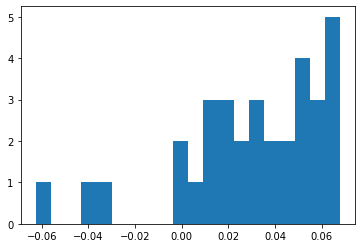

In [22]:
plt.hist(psivalues,bins=20)

In [ ]:
BJDmidP_frequency, psivalues_power = LombScargle(BJDmidP, psivalues).autopower()
plt.plot(BJDmidP_frequency, psivalues_power)
            
highest_frequency_peak_in_psivalues_power = BJDmidP_frequency[np.where(
    psivalues_power==max(psivalues_power[BJDmidP_frequency<nyquist]))[0][0]]

In [ ]:
psivalues_power==max(psivalues_power[BJDmidP_frequency<nyquist])

In [ ]:
FFF(bitBJD, pfit[0], pfit[1], pfit[2], resdict)

In [ ]:
bitBJD = np.asarray(bitBJD)
for each in bitBJD:
    print(type(each))

In [ ]:
for x in range(3):
    print(pfit[x])
    print(type(pfit[x]))

In [ ]:
for each in resdict.values():
    print(type(each))

In [ ]:
bitBJD

In [ ]:
c=0
while True:
    c+=1
    if c%10==0:break
    if c==2:continue
    print(c)

In [ ]:
line.split('/')[0]+'/longcadence/'+line.split('/')[1]

In [ ]:
len(BJDmidP)

In [ ]:
len(avalues)

In [ ]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

import glob
objlist=set(glob.glob('TESS_RRLs/*txt'))-set(glob.glob('TESS_RRLs/*extended_details.txt'))
for index, line in enumerate(objlist):
    print(file_len(line))

In [ ]:
objlist

In [38]:
import pymc

ModuleNotFoundError: No module named 'pymc'

In [40]:
import sys
!{sys.executable} -m pip install pymc

     |████████████████████████████████| 358kB 2.4MB/s eta 0:00:01
  ERROR: Complete output from command /usr/bin/python3.6 -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-6pgej2_a/pymc/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-qag9r_lo --python-tag cp36:
  ERROR: /home/szabopal/.local/lib/python3.6/site-packages/numpy/distutils/system_info.py:639: UserWarning:
      Atlas (http://math-atlas.sourceforge.net/) libraries not found.
      Directories to search for the libraries can be specified in the
      numpy/distutils/site.cfg file (section [atlas]) or by setting
      the ATLAS environment variable.
    self.calc_info()
  /home/szabopal/.local/lib/python3.6/site-packages/numpy/distutils/system_info.py:639: UserWarning:
      Lapack (http://www.netlib.org/lapack/) libraries not found.
      Directories to s

Failed to build pymc
  Running setup.py install for pymc ... error
    ERROR: Complete output from command /usr/bin/python3.6 -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-6pgej2_a/pymc/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-dnsrrure/install-record.txt --single-version-externally-managed --compile:
    ERROR: /home/szabopal/.local/lib/python3.6/site-packages/numpy/distutils/system_info.py:639: UserWarning:
        Atlas (http://math-atlas.sourceforge.net/) libraries not found.
        Directories to search for the libraries can be specified in the
        numpy/distutils/site.cfg file (section [atlas]) or by setting
        the ATLAS environment variable.
      self.calc_info()
    /home/szabopal/.local/lib/python3.6/site-packages/numpy/distutils/system_info.py:639: UserWarning:
        Lapack (http:

ERROR: Command "/usr/bin/python3.6 -u -c 'import setuptools, tokenize;__file__='"'"'/tmp/pip-install-6pgej2_a/pymc/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-dnsrrure/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /tmp/pip-install-6pgej2_a/pymc/


In [41]:
!pwd

/home/szabopal/PycharmProjects/veszprem/veszprembe_vitt_geprol_fajlok/veszpremOC
